In [1]:
import os
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('paper', font_scale=1.2)
import pandas as pd
import scipy.stats
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#Decoder functions
from PlotDecodingResults import ModelPredictionPlots
from RunKeras import PrepareBehaviorData as pbd
from sklearn.model_selection import train_test_split
m = ModelPredictionPlots()
from RunKeras import NaiveBayes as nb
nb = nb()

Using TensorFlow backend.


Validation functions


## Get Data and make final model from saved params

In [3]:
task_dict = {'Task1':'1 Fam Rew', 
             'Task2':'2 No Rew', 
             'Task3':'3 Fam Rew', 
             'Task4':'4 Nov Rew'}

In [4]:
FolderName = '/home/sheffieldlab/Desktop/NoReward/ImagingData/Good_behavior/NR6/'
SaveResults = os.path.join(FolderName, 'DecoderResults', 'BayesDecoder')

frame_lick_stop = 5154
task_numframes = {'Task1': 20000, 
                  'Task2': 20000, 
                  'Task3': 15000, 
                  'Task4': 15000}
#Track Parameters
tracklength = 200 #2m track
trackbins = 5 #5cm bins

In [5]:
from Placecells_and_LickCorrelation_EachAnimal import GetData as gd
A = gd(FolderName=FolderName, Task_NumFrames=task_numframes, TaskDict=task_dict, lick_stop=frame_lick_stop)

Number of PlaceCells in Task2 is 129
Number of PlaceCells in Task1 is 133
Number of PlaceCells in Task3 is 123
Number of PlaceCells in Task4 is 119
Number of PlaceCells in Task2a is 129


## Get Training and testing data

In [6]:
# Get Xdata - calcium data and Ydata - running behavior
X = A.Fc3data_dict['Task1'][:, A.Parsed_Behavior['good_running_index'].item()['Task1']].T[:11100, :]
Y = A.Parsed_Behavior['good_running_data'].item()['Task1'][:11100]
print(np.shape(X), np.shape(Y))

(11100, 316) (11100, 1)


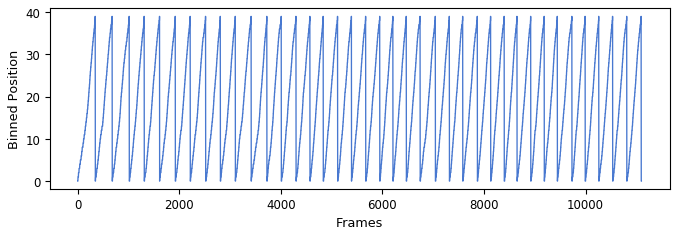

In [7]:
from RunKeras import PrepareBehaviorData as pbd
B = pbd(BehaviorData=Y, tracklength=tracklength, trackbins=trackbins)
y_cat = B.position_binary

In [8]:
#Split testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.10, random_state=None, shuffle=False)
print(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

(9990, 316) (1110, 316) (9990,) (1110,)


### Fit Bayes


Accuracy of test set:: 0.33%


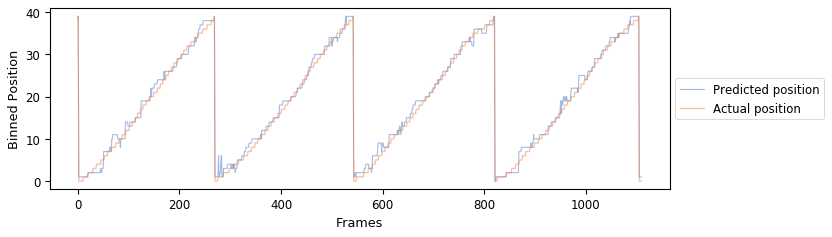

In [9]:
gaussianNB = nb.fit_naivebayes(X_train, y_train)
scores, y_predicted, y_errorprob = nb.validate_model(gaussianNB, X_test, y_test)

### Run model on No reward data

In [10]:
X_norew = A.Fc3data_dict['Task2'][:, A.Parsed_Behavior['good_running_index'].item()['Task2']].T
Y_norew = A.Parsed_Behavior['good_running_data'].item()['Task2']
print(np.shape(X_norew), np.shape(Y_norew))

(10058, 316) (10058, 1)


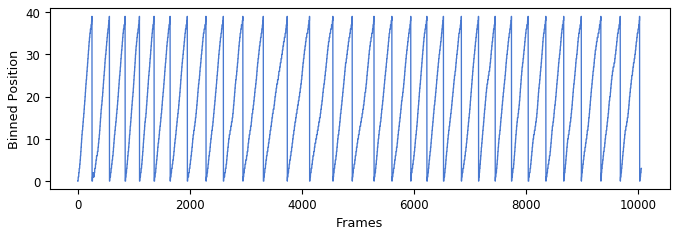

In [11]:
B = pbd(BehaviorData=Y_norew, tracklength=tracklength, trackbins=trackbins)
y_norew_cat = B.position_binary


Accuracy of test set:: 0.15%


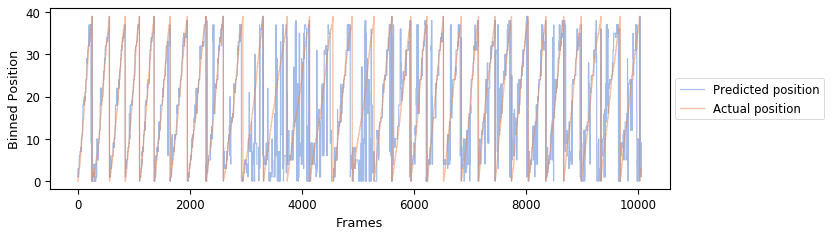

In [12]:
# evaluate the model and save evalautions
scores, ynorew_predict, ynorew_probability = nb.validate_model(gaussianNB, X_norew, y_norew_cat)

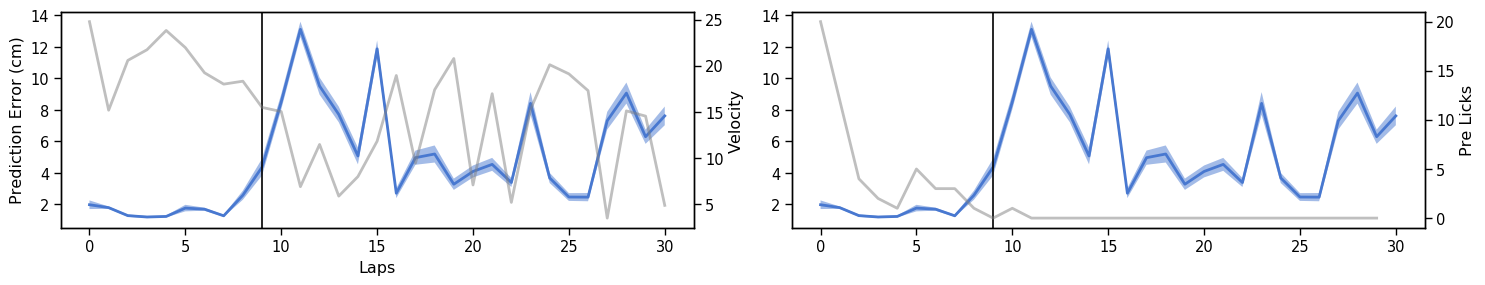

In [13]:
lapframes = [scipy.io.loadmat(os.path.join(A.FolderName, 'Behavior', p))['E'].T for p in A.PlaceFieldData if 'Task2' in p and 'Task2a' not in p][0]
Y_actual = y_norew_cat
Y_predicted = ynorew_predict
numlaps = A.Parsed_Behavior['numlaps'].item()['Task2']
licks = A.Parsed_Behavior['numlicks_withinreward'].item()['Task2']
velocity = tracklength/ np.asarray(A.Parsed_Behavior['actuallaps_laptime'].item()['Task2'])
stoplicklap = A.Parsed_Behavior['lick_stop'].item()
lickstop_goodbeh_frame = np.where(lapframes == stoplicklap)[0][-1]
avg_lapdiff_norew, sem_lapdiff_norew = m.PlotLapwiseAccuracy(lapframes, Y_actual, Y_predicted, numlaps, licks, velocity, stoplicklap)

In [14]:
# Print mean correlation and mean R2
R2_before = m.get_R2(Y_actual[:lickstop_goodbeh_frame],
                     Y_predicted[:lickstop_goodbeh_frame])
rho_before = m.get_rho(
    Y_actual[:lickstop_goodbeh_frame], Y_predicted[:lickstop_goodbeh_frame])
print(f'R2 before lick stops: %.2f' % R2_before)
print(f'Rho before lick stops: %.2f' % rho_before)
R2_after = m.get_R2(Y_actual[lickstop_goodbeh_frame:],
                    Y_predicted[lickstop_goodbeh_frame:])
rho_after = m.get_rho(
    Y_actual[lickstop_goodbeh_frame:], Y_predicted[lickstop_goodbeh_frame:])
print(f'R2 after lick stops: %.2f' % R2_after)
print(f'Rho after lick stops: %.2f' % rho_after)

R2 before lick stops: 0.90
Rho before lick stops: 0.95
R2 after lick stops: 0.02
Rho after lick stops: 0.56


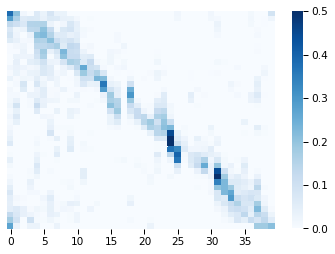

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_actual, Y_predicted)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, cmap="Blues",  xticklabels=5, yticklabels=False, vmin=0, vmax=0.5)

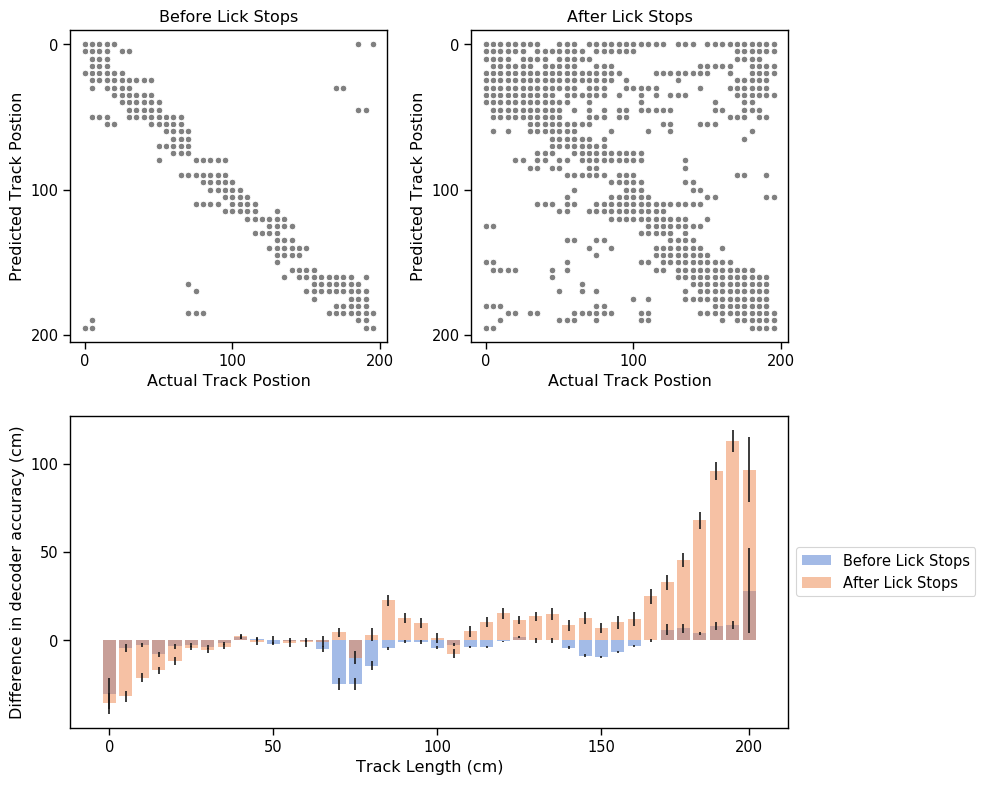

In [15]:
#Plot fitting accuracy before and after reward
m.plot_accuracy_beforeandaft_lickstops(Y_actual, Y_predicted, lickstop_goodbeh_frame, tracklength, trackbins)

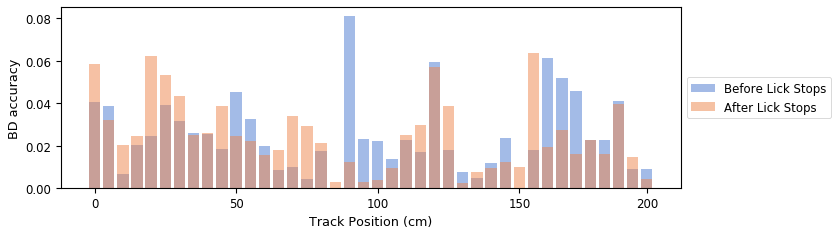

In [16]:
m.plot_bayeserrorprob_beforeandaft_lick(ynorew_probability, lickstop_goodbeh_frame, trackbins)

In [17]:
np.savez(os.path.join(SaveResults, 'FitwithNoReward.npz'), 
         y_actual=Y_actual, y_predicted=Y_predicted, y_probability=ynorew_probability,
         R2_before=R2_before, rho_before=rho_before, R2_after=R2_after, rho_after=rho_after,
         numlaps=numlaps, lapframes=lapframes,
         licks=licks, velocity=velocity, stoplicklap=stoplicklap, 
         avg_lapdiff = avg_lapdiff_norew, sem_lapdiff=sem_lapdiff_norew)

### Run Model on Reward 2

In [18]:
X_rew2 = A.Fc3data_dict['Task3'][:, A.Parsed_Behavior['good_running_index'].item()['Task3']].T
Y_rew2 = A.Parsed_Behavior['good_running_data'].item()['Task3']
print(np.shape(X_rew2), np.shape(Y_rew2))

(7072, 316) (7072, 1)


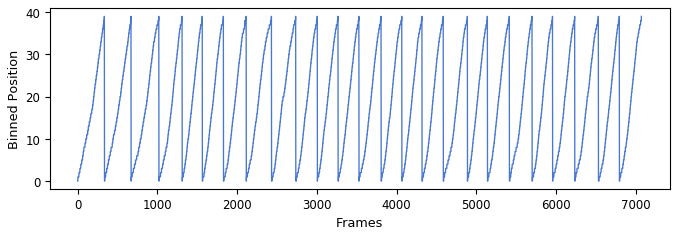

In [19]:
B = pbd(BehaviorData=Y_rew2, tracklength=tracklength, trackbins=trackbins)
y_rew2_cat = B.position_binary


Accuracy of test set:: 0.14%


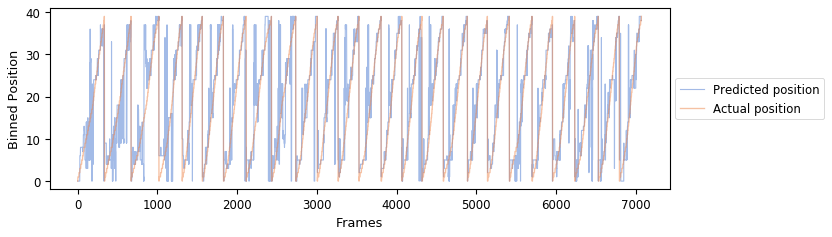

In [20]:
# evaluate the model and save evalautions
scores, yrew2_predict, yrew2_probability = nb.validate_model(gaussianNB, X_rew2, y_rew2_cat)

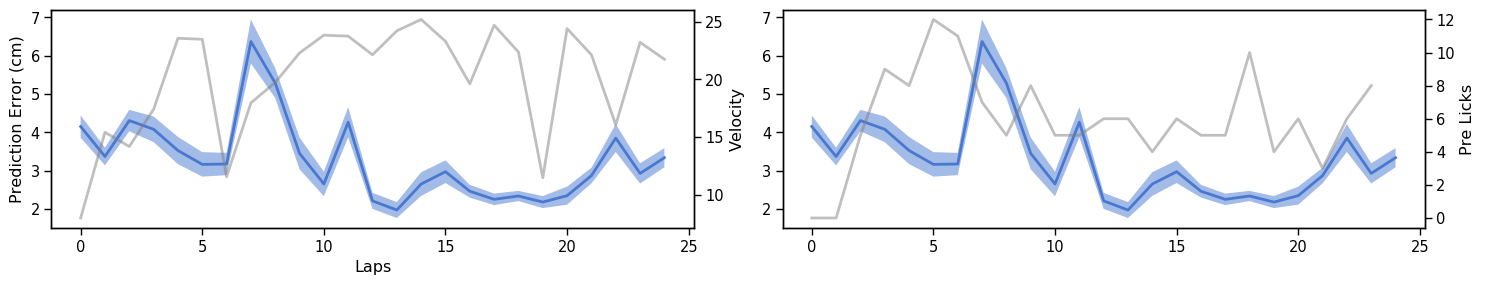

In [21]:
lapframes = [scipy.io.loadmat(os.path.join(A.FolderName, 'Behavior', p))['E'].T for p in A.PlaceFieldData if 'Task3' in p][0]
Y_actual = y_rew2_cat
Y_predicted = yrew2_predict
numlaps = A.Parsed_Behavior['numlaps'].item()['Task3']
licks = A.Parsed_Behavior['numlicks_withinreward'].item()['Task3']
velocity = tracklength/ np.asarray(A.Parsed_Behavior['actuallaps_laptime'].item()['Task3'])
avg_lapdiff_rew, sem_lapdiff_rew = m.PlotLapwiseAccuracy(lapframes, Y_actual, Y_predicted, numlaps, licks, velocity)

Text(0, 0.5, 'Predicted Track Postion')

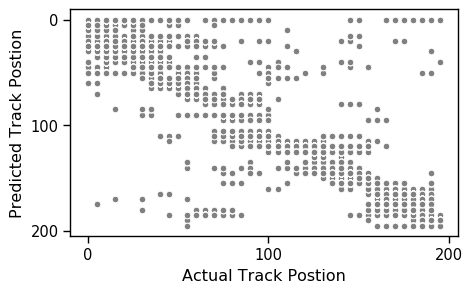

In [22]:
fs, ax1 = plt.subplots(1, figsize=(5, 3), dpi=100)
sns.scatterplot(Y_actual * trackbins, Y_predicted * trackbins, color='gray', ax=ax1)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.locator_params(nbins=4)
ax1.set_xlabel('Actual Track Postion')
ax1.set_ylabel('Predicted Track Postion')

In [23]:
# Print mean correlation and mean R2
R2_rew2 = m.get_R2(Y_actual, Y_predicted)
rho_rew2 = m.get_rho(Y_actual, Y_predicted)
print(f'R2: %.2f' %R2_rew2)
print(f'Rho: %.2f' %rho_rew2)

R2: 0.75
Rho: 0.88


In [24]:
np.savez(os.path.join(SaveResults, 'FitwithReward.npz'), 
         y_actual=Y_actual, y_predicted=Y_predicted, y_probability=yrew2_probability,
         R2=R2_rew2, rho=rho_rew2, numlaps=numlaps, lapframes=lapframes,
         licks=licks, velocity=velocity, avg_lapdiff = avg_lapdiff_rew, sem_lapdiff=sem_lapdiff_rew)

### Run Model on Novel data

In [25]:
X_nov = A.Fc3data_dict['Task4'][:, A.Parsed_Behavior['good_running_index'].item()['Task4']].T
Y_nov = A.Parsed_Behavior['good_running_data'].item()['Task4']
print(np.shape(X_nov), np.shape(Y_nov))

(11044, 316) (11044, 1)


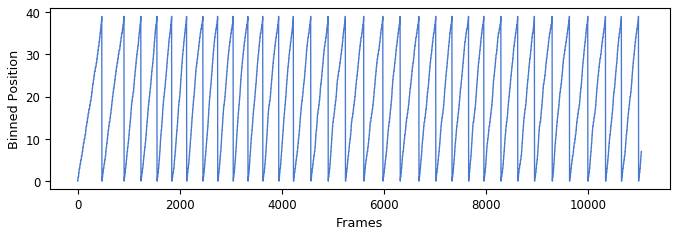

In [26]:
B = pbd(BehaviorData=Y_nov, tracklength=tracklength, trackbins=trackbins)
y_nov_cat = B.position_binary


Accuracy of test set:: 0.05%


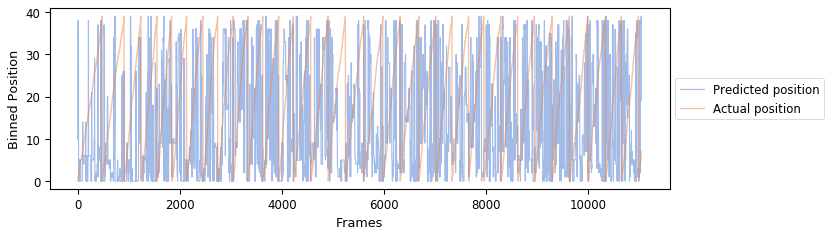

In [27]:
# evaluate the model and save evalautions
scores, ynov_predict, ynov_probability = nb.validate_model(gaussianNB, X_nov, y_nov_cat)

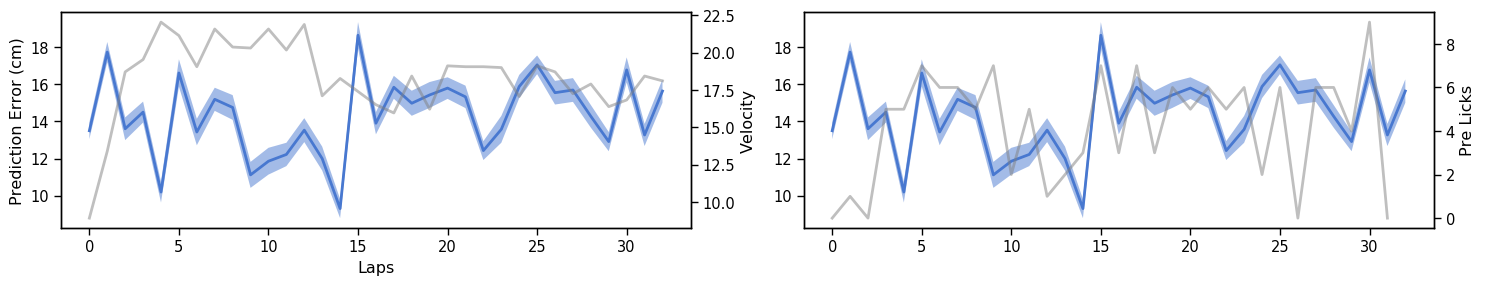

In [28]:
lapframes = [scipy.io.loadmat(os.path.join(A.FolderName, 'Behavior', p))['E'].T for p in A.PlaceFieldData if 'Task4' in p][0]
Y_actual = y_nov_cat
Y_predicted = ynov_predict
numlaps = A.Parsed_Behavior['numlaps'].item()['Task4']
licks = A.Parsed_Behavior['numlicks_withinreward'].item()['Task4']
velocity = tracklength/ np.asarray(A.Parsed_Behavior['actuallaps_laptime'].item()['Task4'])
avg_lapdiff_novel, sem_lapdiff_novel = m.PlotLapwiseAccuracy(lapframes, Y_actual, Y_predicted, numlaps, licks, velocity)

Text(0, 0.5, 'Predicted Track Postion')

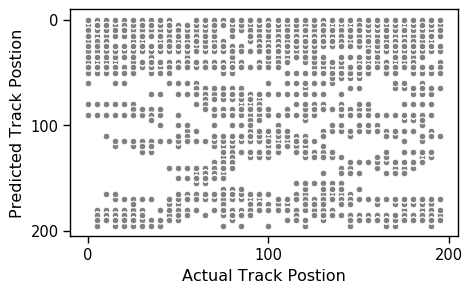

In [29]:
fs, ax1 = plt.subplots(1, figsize=(5, 3), dpi=100)
sns.scatterplot(Y_actual * trackbins, Y_predicted * trackbins, color='gray', ax=ax1)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.locator_params(nbins=4)
ax1.set_xlabel('Actual Track Postion')
ax1.set_ylabel('Predicted Track Postion')

In [30]:
# Print mean correlation and mean R2
R2_nov = m.get_R2(Y_actual, Y_predicted)
rho_nov = m.get_rho(Y_actual, Y_predicted)
print(f'R2: %.2f' %R2_nov)
print(f'Rho: %.2f' %rho_nov)

R2: -1.38
Rho: 0.07


In [31]:
np.savez(os.path.join(SaveResults, 'FitwithNovel.npz'), 
         y_actual=Y_actual, y_predicted=Y_predicted, y_probability=ynov_probability,
         R2=R2_nov, rho=rho_nov, numlaps=numlaps, lapframes=lapframes,
         licks=licks, velocity=velocity, avg_lapdiff = avg_lapdiff_novel, sem_lapdiff=sem_lapdiff_novel)

### Plot Average decoding error per task

In [32]:
#Get k-fold validation error for training data
controlerror = pd.read_pickle(os.path.join(SaveResults, '5-foldevaluation.pkl'))

In [33]:
mean_error_terms = [np.mean(controlerror['Y_diff'].to_list(), 1), 
                    avg_lapdiff_norew[:stoplicklap],
                    avg_lapdiff_norew[stoplicklap:],
                    avg_lapdiff_rew,
                    avg_lapdiff_novel]
plot_x_label = ['Control', 'NoRew_withlick', 'NoRew_nolick', 'Rew2', 'Novel']

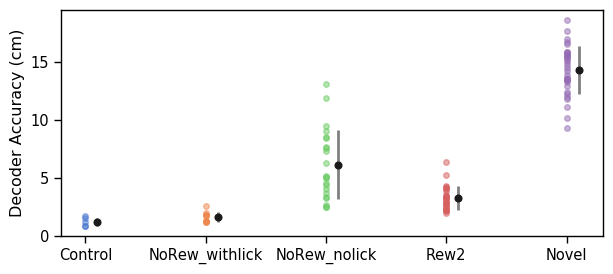

In [34]:
plt.figure(figsize=(7, 3), dpi=100)
for num, mean in enumerate(mean_error_terms):
    plt.plot(np.ones(np.size(mean))*num, mean, '.', alpha=0.5, markersize=8)
    plt.errorbar(num+0.1, np.mean(mean), yerr=np.std(mean), fmt='o', capthick=2,
                 linewidth=2, ecolor='gray', color='k')
plt.locator_params(nbins=4)
plt.xticks(np.arange(np.size(plot_x_label)), plot_x_label)
plt.ylabel('Decoder Accuracy (cm)');

In [35]:
ground_truth = np.load(os.path.join(SaveResults, 'FinalBayesFit.npz'))

In [36]:
R2 = [ground_truth['R2'].item(), 
                    R2_before,
                    R2_after,
                    R2_rew2,
                    R2_nov]
plot_x_label = ['Control', 'NoRew_Bef', 'NoRew_Aft', 'Rew2', 'Novel']

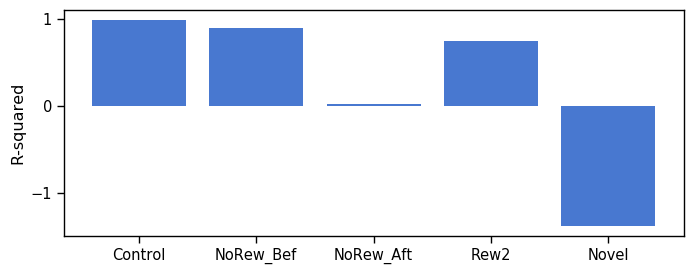

In [37]:
plt.figure(figsize=(8, 3), dpi=100)
plt.bar(np.arange(len(R2)), R2);
plt.xticks(np.arange(np.size(plot_x_label)), plot_x_label)
plt.locator_params(axis='y', nbins=3)
plt.ylabel('R-squared');